In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Recommendation systems: Deep Model

This model is made up of feature layers that have users, movies and movie genres embedings followed by a neural network with dense layers and finally one output that is the rating prediction that input user(id) could assign to input movie(id).

**Inputs**
* **User id**: Really this is traducet as a sequence because embedding layers only can manage sequenced identifiers.
* **Movie id**: Idem to User id.
* **Movie genres**: One column by genre.

**Output**
*  **Rating prediction** that user could assign to movie.

**Links**
* [Deep Learning With Keras: Recommender Systems](https://www.johnwittenauer.net/deep-learning-with-keras-recommender-systems/)
* [Collaborative Filtering for Movie Recommendations](https://keras.io/examples/structured_data/collaborative_filtering_movielens/)
* [Movie lens datasets](https://grouplens.org/datasets/movielens/)
* [Recommendation Systems Benchmarks](https://paperswithcode.com/task/recommendation-systems)

## Required libraries

In [2]:
import sys
sys.path.append('../src')

import os
from util import create_path, remove_dir

def show_env_var(varname):
    if varname in os.environ:
        print(f'{varname}: {os.environ[varname]}')
    else:
        print(f'{varname} undefined')

In [3]:
user_ray = False

if user_ray:    
    show_env_var('MODIN_OUT_OF_CORE')
    show_env_var('MODIN_MEMORY')
    show_env_var('MODIN_ON_RAY_PLASMA_DIR')

    create_path(os.environ['MODIN_ON_RAY_PLASMA_DIR'])

    import ray
    import modin
    import modin.pandas as pd
    
    modin.__version__

    # ray.shutdown()
    if not ray.is_initialized():
        ray.init(num_cpus=24, num_gpus=1, dashboard_host="0.0.0.0", dashboard_port=8080)
    else:
        print('Ray is already active!')
else:
    import pandas as pd

In [4]:
import math

import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import keras_tuner as kt
from util import tf_detected_devices, tf_version, plot_model, Config, LoggerFactory, create_path

from callback import MetricsPlotter
from data import InMemoryXyDataGenerator
from recommendation import UserMovieGenderEmbeddingDenseModelFactory

import matplotlib.pyplot as plt
import logging
import warnings

from data import MovieLensDataSource

## Helpers

In [5]:
GENDER_COLUMNS = [
    'gen_film_noir', 
    'gen_none', 
    'gen_imax', 
    'gen_documentary',
    'gen_romance', 
    'gen_drama', 
    'gen_adventure', 
    'gen_western',
    'gen_animation',
    'gen_mystery', 
    'gen_fantasy',
    'gen_action', 
    'gen_comedy', 
    'gen_sci_fi', 
    'gen_musical',
    'gen_war', 
    'gen_crime', 
    'gen_children', 
    'gen_horror', 
    'gen_thriller'
]
X_COLUMNS = ['user_seq', 'movie_seq'] + GENDER_COLUMNS
Y_COLUMNS = ['rating']

In [6]:
def log_counts(train_set, val_set, test_set):
    logging.info(f'Train set count = {train_set.shape[0]} observations.')
    logging.info(f'Validation set count = {val_set.shape[0]} observations.')
    logging.info(f'Test set count = {test_set.shape[0]} observations.')

In [7]:
def evaluate(model, samples, batch_size):
    X, y = samples[X_COLUMNS].values, samples[Y_COLUMNS].values
    
    generator = InMemoryXyDataGenerator(
        X,
        y, 
        batch_size,
        shuffle=True, 
        to_input=to_input
    )
    X_batch, y_batch = generator[0]
    
    return model.evaluate(X_batch, y_batch, batch_size=batch_size, verbose=0)

In [8]:
def get_best_hyperparameters(tuner):
    return tuner.get_best_hyperparameters(num_trials=1)[0]

def create_best_model_from(tuner):
    return tuner.hypermodel.build(get_best_hyperparameters(tuner))

In [9]:
def lowest_loss_epoch(val_loss_per_epoch):
    return val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1

In [10]:
def plot_loss(losses, xlabel='Epoch', ylabel='Loss', title='Loss by epoch'):
    plt.plot(list(range(1, len(losses)+1)), losses)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [11]:
import random

class Dataset:
    def __init__(self, observations):
        self.observations = observations
 
    def search_by_seqs(self, user_seq, movie_seq): 
        return self.observations[(self.observations.user_seq == user_seq) & (self.observations.movie_seq == movie_seq)]

    def random_observation(self,  has_rating=True):
        """
        Get a random observation.
        """
        finish = True
        while finish:
            user_seq  = random.choice(self.observations['user_seq'])
            movie_seq = random.choice(self.observations['movie_seq'])
        
            sample = self.search_by_seqs(user_seq, movie_seq)
    
            finish = sample.empty if has_rating else not sample.empty

        return sample.head(1)

In [62]:
def predict(model, samples, batch_size):
    X = samples[X_COLUMNS].values
    y = samples[Y_COLUMNS].values
 
    generator = InMemoryXyDataGenerator(
        X,
        y, 
        batch_size,
        shuffle=True, 
        to_input=to_input
    )
    X_batch, y_batch = generator[0]

    y_predicted = model.predict(X_batch, batch_size=batch_size, verbose=0)

    result = samples.copy()
    result.insert(0, 'pred_rating', y_predicted) 
    return result 

def to_percent(value): return round(value * 100, 2)

def get_metrics(
    dataset,
    max_error   = 1, 
    sample_size = 1000,
    loss_fn     = lambda y_pred, y_true : abs(y_pred - y_true)
):
    true_positives = false_positives = 0
    error_dits     = []

    for index in range(0, sample_size):
        observation = dataset.random_observation()

        prediction = predict(model, observation, batch_size=observation.shape[0])

        y_pred = prediction['pred_rating'].item()
        y_true = prediction['rating'].item()

        error = loss_fn(y_pred, y_true)
        error_dits.append(error)

        if  error <= max_error:
            true_positives  +=1
        else:
            false_positives +=1

    return {
        'true_positives':  f'{to_percent(true_positives / sample_size)}%',
        'false_positives': f'{to_percent(false_positives / sample_size)}%',
        'error_dist':      error_dits
    }

## Logger config

In [13]:
tf.get_logger().setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [14]:
config = Config(path='../config/config.yaml')
LoggerFactory(config['logger']).create()

<RootLogger root (INFO)>

## Check environment

**Step 1**: Make sure that nvidia driver is installed runing next command:

In [15]:
!nvidia-smi --query-gpu=gpu_name,memory.total --format=csv | sed -n 2p

NVIDIA GeForce RTX 3080, 10240 MiB


**Note:** If this shows a GPU model and memory size, that's all right, otherwise make suze that has the nvidia driver installed.

**Step 2**: Let's check tensorflow version:

In [16]:
tf_version()

'Tensorflow version: 2.8.0'

**Step 3**: Let's check devices that tensorflow detect:

In [17]:
tf_detected_devices()

,Name,Device Type,Memory,Description
0,/device:CPU:0,CPU,256M,
1,/device:GPU:0,GPU,6G,"device: 0, name: NVIDIA GeForce RTX 3080, pci ..."


In [18]:
tf.debugging.set_log_device_placement(False)

**Step 4**: Make sure that tensorflow detect cuda libs and GPU devices.

In [19]:
tf.test.is_built_with_cuda()

True

In [20]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Prepare model input data

**Step 1**: Load train, val and test sets.

In [21]:
TEMP_PATH = './temp'
TRAIN_PATH = f'{TEMP_PATH}/train'
VAL_PATH = f'{TEMP_PATH}/val'
TEST_PATH = f'{TEMP_PATH}/test'

train  = True

In [22]:
import glob

def read_csv(path):
    all_files = glob.glob(path)
    li = [pd.read_csv(filename, index_col=None, header=0) for filename in all_files]
    return pd.concat(li, axis=0, ignore_index=True)

In [23]:
train_set = read_csv(f'{TRAIN_PATH}/*.csv')
val_set   = read_csv(f'{VAL_PATH}/*.csv')
test_set  = read_csv(f'{TEST_PATH}/*.csv')

log_counts(train_set, val_set, test_set)

2022-02-27 00:49:35 INFO Train set count = 70288 observations.
2022-02-27 00:49:35 INFO Validation set count = 20198 observations.
2022-02-27 00:49:35 INFO Test set count = 8851 observations.


**Step 2:** Let's see min and max value of rating column.

In [24]:
min_rating, max_rating = train_set['rating'].min(), train_set['rating'].max()

logging.info(f'Rattings:\n - min = {min_rating}\n - max = {max_rating}')

2022-02-27 00:49:35 INFO Rattings:
 - min = 0.5
 - max = 5.0


**Step 3:** Calculate train and val batch size and plot interval.

In [25]:
steps             = 100
epochs            = 80
plot_interval     = math.floor(steps / 2)

train_batch_size  = math.floor(train_set.shape[0] / steps)
val_batch_size    = math.floor(val_set.shape[0] / steps)
evaluate_interval = plot_interval + 1

logging.info(f'Steps: {steps}, Epochs: {epochs}.')
logging.info(f'Batch Size = (Train:{train_batch_size}, Val:{val_batch_size}).')
logging.info(f'Interval = (Plot:{plot_interval}, Evaluate:{evaluate_interval}).')

2022-02-27 00:49:35 INFO Steps: 100, Epochs: 80.
2022-02-27 00:49:35 INFO Batch Size = (Train:702, Val:201).
2022-02-27 00:49:35 INFO Interval = (Plot:50, Evaluate:51).


train_set**Step 4:** build tran, validation and test matrix, excluding ids for inputs.

In [26]:
GENDER_COLUMNS = [
    'gen_film_noir', 
    'gen_none', 
    'gen_imax', 
    'gen_documentary',
    'gen_romance', 
    'gen_drama', 
    'gen_adventure', 
    'gen_western',
    'gen_animation',
    'gen_mystery', 
    'gen_fantasy',
    'gen_action', 
    'gen_comedy', 
    'gen_sci_fi', 
    'gen_musical',
    'gen_war', 
    'gen_crime', 
    'gen_children', 
    'gen_horror', 
    'gen_thriller'
]
X_COLUMNS = ['user_seq', 'movie_seq'] + GENDER_COLUMNS
Y_COLUMNS = ['rating']

In [27]:
X_train = train_set[X_COLUMNS].values
y_train = train_set[Y_COLUMNS].values

In [28]:
X_val = val_set[X_COLUMNS].values
y_val = val_set[Y_COLUMNS].values

In [29]:
X_test = test_set[X_COLUMNS].values
y_test = test_set[Y_COLUMNS].values

**Step 5:** Define data generator. A data generator is used to provide next observations batch to model under training process both to forward pass and also to get a validation batch.

In [30]:
def to_input(X, y): return [X[:, 0],  X[:, 1], X[:, 2:22]], y

In [31]:
train_generator = InMemoryXyDataGenerator(
    X_train, 
    y_train,
    train_batch_size,
    shuffle  = True,
    to_input = to_input
)

val_generator = InMemoryXyDataGenerator(
    X_val, 
    y_val, 
    val_batch_size, 
    shuffle  = True,
    to_input = to_input
)

test_generator = InMemoryXyDataGenerator(
    X_test, 
    y_test, 
    train_batch_size, 
    shuffle  = True,
    to_input = to_input
)

Check train batch shape:

In [32]:
batch = train_generator[0]

logging.info(f'Train Batch columns: Users: {batch[0][0].shape}, Movies: {batch[0][1].shape}, genders:{batch[0][2].shape}')

2022-02-27 00:49:36 INFO Train Batch columns: Users: (702,), Movies: (702,), genders:(702, 20)


In [33]:
logging.info(f'user_seq: {batch[0][0][0]}')
logging.info(f'movie_seq: {batch[0][1][0]}')
logging.info(f'genders: {batch[0][2][0]}')

2022-02-27 00:49:36 INFO user_seq: 36
2022-02-27 00:49:36 INFO movie_seq: 509
2022-02-27 00:49:36 INFO genders: [0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0]


Check users/movies sequence count:

In [34]:
user_ids = set(np.concatenate((
    train_set['user_id'].values,
    val_set['user_id'].values,
    test_set['user_id'].values
), axis=0))

n_users = len(user_ids)
n_users

610

In [35]:
movie_ids = set(np.concatenate((
    train_set['movie_id'].values, 
    val_set['movie_id'].values,
    test_set['movie_id'].values
), axis=0))

n_movies = len(movie_ids)
n_movies

8454

# Model definition

In [36]:
def create_metrics_callback():
    return MetricsPlotter(
        validation_generator = val_generator, 
        metrics_names        = ['loss'],
        plot_interval        = plot_interval,
        evaluate_interval    = evaluate_interval,
        batch_size           = train_batch_size,
        val_batch_size       = val_batch_size
    )

def create_checkpoints_callback():
    checkpoint_file = \
        create_path('./checkpoints') + \
        '/weights.epoch_{epoch:02d}-loss_{loss:.3f}-val_loss_{val_loss:.3f}.hdf5'

    return ModelCheckpoint(
        filepath          = checkpoint_file,
        save_weights_only = True,
        monitor           = 'val_loss',
        mode              = 'max',
        save_best_only    = True
    )

In [37]:
def model_builder(hp):  
    # Hyperparameters
    lr       = hp.Choice('lr', values=[0.01, 0.001, 0.001])

    units1   = hp.Int('units1', min_value=10, max_value=200, step=10)  
    dropout1 = hp.Float('dropout1', min_value=0.1, max_value=0.9, step=0.1)

    units2   = hp.Int('units2', min_value=10, max_value=200, step=10)
    dropout2 = hp.Float('dropout2', min_value=0.1, max_value=0.9, step=0.1)
      
    units3   = hp.Int('units3', min_value=10, max_value=200, step=10)
    dropout3 = hp.Float('dropout3', min_value=0.1, max_value=0.9, step=0.1)

    user_embeding_vector_size  = hp.Int(
      'usersfactor', min_value=10, max_value=50, step=10
    )
    movie_embeding_vector_size = hp.Int(
      'moviesfactor', min_value=10, max_value=50, step=10
    )

    return UserMovieGenderEmbeddingDenseModelFactory.create(
        n_users, 
        n_movies,
        n_genders           = len(GENDER_COLUMNS),
        min_rating          = min_rating,
        max_rating          = max_rating,
        user_n_min_factors  = user_embeding_vector_size,
        movie_n_min_factors = movie_embeding_vector_size,
        lr                  = lr,
        units               = [units1,   units2,   units3],
        dropout             = [dropout1, dropout2, dropout3]
    )

    return model

# Search best model hyper parameters

**Step 1**: Create an optimizer to search bestmodel hyper aprams give a set of optimmmmmizer hyperparams.

In [38]:
path = create_path('./tunes')

tuner = kt.Hyperband(
    model_builder,
    objective    = 'val_loss',
    max_epochs   = 50,
    factor       = 3,
    directory    = path,
    project_name = 'recommendations'
)

tuner.search_space_summary()

Search space summary
Default search space size: 9
lr (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.001], 'ordered': True}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 200, 'step': 10, 'sampling': None}
dropout1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.9, 'step': 0.1, 'sampling': None}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 200, 'step': 10, 'sampling': None}
dropout2 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.9, 'step': 0.1, 'sampling': None}
units3 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 200, 'step': 10, 'sampling': None}
dropout3 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.9, 'step': 0.1, 'sampling': None}
usersfactor (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 50, 'step': 10, 'sampling': None}
moviesfactor (Int)
{'default': None,

In [39]:
tuner.search(
    train_generator,
    validation_data     = val_generator,
    callbacks           = [EarlyStopping(monitor='val_loss', patience=5)],
    use_multiprocessing = True
)

Trial 90 Complete [00h 00m 14s]
val_loss: 0.7475868463516235

Best val_loss So Far: 0.7299972176551819
Total elapsed time: 00h 12m 35s


**Step 2**: Show best model hyperparameters give a set of optimizer hyperparams:

In [40]:
# Show a summary of the search
tuner.results_summary(num_trials=1)

Results summary
Results in ./tunes/recommendations
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
lr: 0.001
units1: 140
dropout1: 0.4
units2: 30
dropout2: 0.7000000000000001
units3: 200
dropout3: 0.4
usersfactor: 40
moviesfactor: 20
tuner/epochs: 17
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.7299972176551819


**Step 3**: Get best model founded by the optimizer:

In [41]:
best_model = tuner.get_best_models(num_models=1)[0]

Evaluate best model on train validation an test sets to see loss:

In [42]:
evaluate(best_model, train_set, batch_size=train_batch_size)

0.5946584343910217

In [43]:
evaluate(best_model, val_set, batch_size=val_batch_size)

0.7116602659225464

In [44]:
evaluate(best_model, test_set, batch_size=val_batch_size)

0.6676213145256042

**Observations**

* Loss under train set of greater than evalidation set. This good a signal.
* Loss under evaliadtion an test sets if pratically the same.

# Train model

**Step 1**: Create model with best founded hyperparameters.

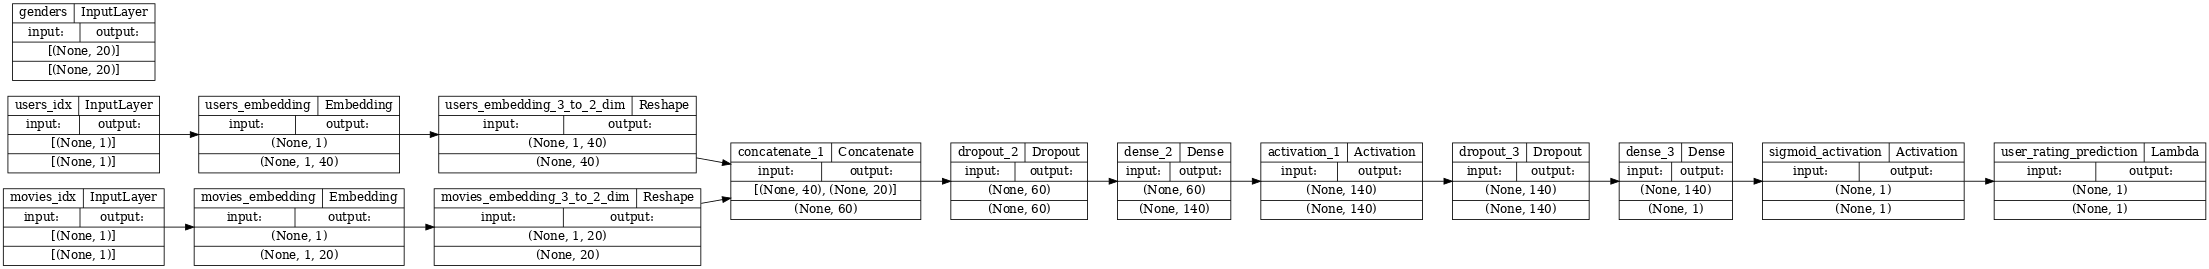

In [45]:
model = create_best_model_from(tuner) 
plot_model(model)

In [46]:
model.summary()

Model: "Embedding_Feature_Layers_Plus_Dense_Layer_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 users_idx (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 movies_idx (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 users_embedding (Embedding)    (None, 1, 40)        24400       ['users_idx[0][0]']              
                                                                                                  
 movies_embedding (Embedding)   (None, 1, 20)        169080      ['movies_idx[0][0]']             
                                                    

**Step 2**: Train model under train set only and plot train vs validation loss by epoch:

In [47]:
hyperparameters = get_best_hyperparameters(tuner)

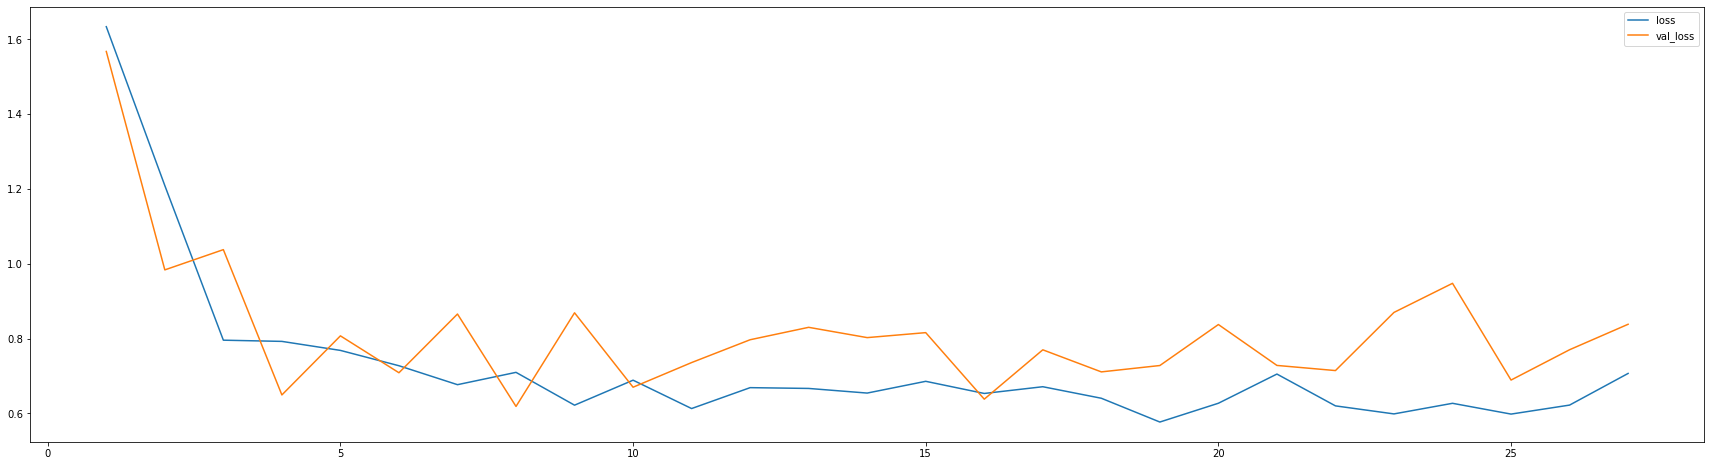

 51/100 [==============>...............] - ETA: 0s - loss: 0.6097

Evaluate model each 51 steps(Batch-size: 201):
1/1 [==============================] - 0s 11ms/step - loss: 0.5603

Val metrics:
  - Loss (28): 0.560304 (⟱ 0.27791119)

Continue model train:
100/100 [==============================] - 2s 15ms/step - loss: 0.6130 - val_loss: 0.7579


In [48]:
history = model.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[
        create_metrics_callback(), 
        create_checkpoints_callback(),
        EarlyStopping(monitor='val_loss', patience=5)
    ],
    use_multiprocessing=True,
    verbose=1
)

**Step 3**: Evaluate model under train, validaiton an test set to see loss diferences. 

In [49]:
evaluate(model, train_set, batch_size=train_batch_size)

0.5383597612380981

In [50]:
evaluate(model, val_set, batch_size=val_batch_size)

0.9333459138870239

In [51]:
evaluate(model, test_set, batch_size=val_batch_size)

0.6041925549507141

**Observations**

* Again, loss under train set is greater than evalidation set. This good a signal.
* Loss under evaluation set is less thant test sets, this is normal. Because test set have never been seen by the model but evalidation set was used to optimize the model.
* Tran vs validation loss are very close each other, is a good signal. In principle, there is no overfitting.

**Step 4**: Now we search epoch with lowest loss value.

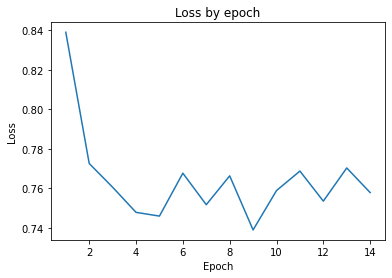

2022-02-27 01:02:38 INFO Lowest loss epoch: 9


In [52]:
val_loss_per_epoch = history.history['val_loss']
plot_loss(val_loss_per_epoch)

epochs = lowest_loss_epoch(val_loss_per_epoch)
logging.info(f'Lowest loss epoch: {epochs}')

**Step 5**: Re train best model trainig only with lowest loss epoch value. 

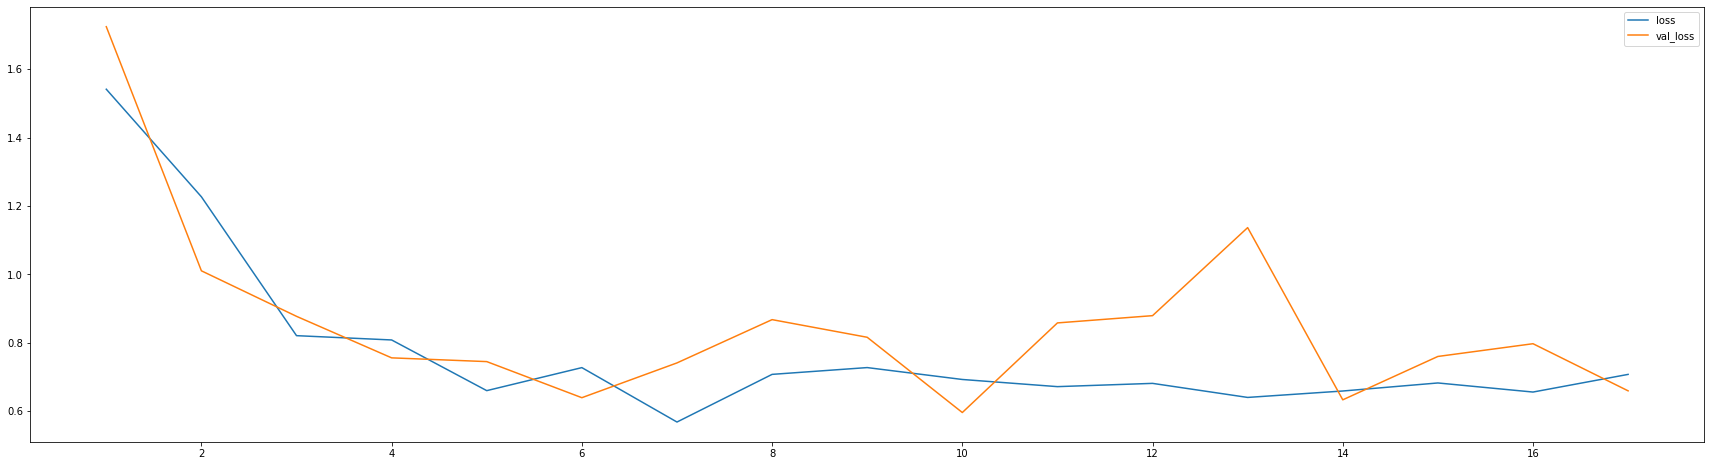

 51/100 [==============>...............] - ETA: 0s - loss: 0.6463

Evaluate model each 51 steps(Batch-size: 201):
1/1 [==============================] - 0s 10ms/step - loss: 0.5765

Val metrics:
  - Loss (18): 0.576534 (⟱ 0.08221471)

Continue model train:
100/100 [==============================] - 2s 17ms/step - loss: 0.6499 - val_loss: 0.7701


In [53]:
model = create_best_model_from(tuner)

history = model.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[
        create_metrics_callback(), 
        create_checkpoints_callback(),
        EarlyStopping(monitor='val_loss', patience=5)
    ],
    use_multiprocessing=True,
    verbose=1
)

In [54]:
evaluate(model, train_set, batch_size=train_batch_size)

0.6127774715423584

In [55]:
evaluate(model, val_set, batch_size=val_batch_size)

0.8059243559837341

In [56]:
evaluate(model, test_set, batch_size=val_batch_size)

0.8121660351753235

**Observations**

* In this cause we found a model with less loss under test set.

## Check rating prediction

Predict ratings used to train model:

In [63]:
train_dataset = Dataset(train_set)
val_dataset   = Dataset(val_set)
test_dataset  = Dataset(test_set)

In [72]:
loss_fn  = lambda y_pred, y_true: abs(y_pred - y_true)
max_error = 0.75

In [73]:
train_metrics = get_metrics(train_dataset, max_error=max_error)

{k: train_metrics[k] for k in ('true_positives', 'false_positives')}

{'true_positives': '69.8%', 'false_positives': '30.2%'}

In [74]:
val_metrics = get_metrics(val_dataset, max_error=max_error)

{k: val_metrics[k] for k in ('true_positives', 'false_positives')}

{'true_positives': '67.9%', 'false_positives': '32.1%'}

In [75]:
test_metrics = get_metrics(test_dataset, max_error=max_error)

{k: test_metrics[k] for k in ('true_positives', 'false_positives')}

{'true_positives': '68.1%', 'false_positives': '31.9%'}